<a href="https://colab.research.google.com/github/bnel1201/XCIST_demo/blob/main/opensource_radiography_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # XCIST wth Open Source Virtual Patient Data

 [XCIST](https://github.com/xcist/main) is a CT simulation framework well suited for running virtual imaging trials due to its high level interface that enables simple, yet flexible, parameterization of CT scanning and reconstruction parameters. It also works well with different formats of virtual patient phantoms such as NURBS phantoms used by XCAT or voxelized phantoms. More details on XCST can be found in there [paper](https://iopscience.iop.org/article/10.1088/1361-6560/ac9174/pdf) or in [these slides](XCIST_dlir_demo.pdf).


 ## Preparing the Dataset
 First we download the dataset and some of the associated tools. Note: this part of the demo was quickly copy-pasted from the [data source's own demo notebook](https://github.com/effepivi/gvxr-CMPB/blob/main/1-gVirtualXRay_vs_Gate-detector_realistic_phantom.ipynb) so some of the install libraries and code below is likely unnecesarry, I will work to clean it up over time.

In [15]:
import os
import urllib

if not os.path.exists("pediatric_phantom_data"):
    os.mkdir("pediatric_phantom_data")

files = ['https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/pediatric_phantom_data/labels.dat',
         'https://raw.githubusercontent.com/bnel1201/XCIST_demo/main/DICOM_to_voxelized_phantom.py']

for url in files:
    fname = url.split('main/')[1]
    if not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)

In [16]:
!pip install --upgrade --quiet SimpleITK pandas pydicom tqdm

## Prepare a phantom for simulation

In [18]:
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path
from pydicom import dcmread, dcmwrite
from pydicom.data import get_testdata_file

if not os.path.exists("pediatric_phantom_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1", "pediatric_phantom_data/Pediatric phantom.zip")

    with zipfile.ZipFile("pediatric_phantom_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall("pediatric_phantom_data")

phantom =  sitk.GetArrayFromImage(sitk.ReadImage("pediatric_phantom_data/Pediatric phantom/Pediatric_model.mhd"))

df = pd.read_csv("pediatric_phantom_data/labels.dat")

materials_dict = {
    'Air': ['air', -1000],
    'Muscle' : ['ICRU_muscle_adult', 55],
    'Bone' : ['CIRS_bone_10yo', 300],
    'Stomach-Interior': ['ncat_intestine', 10],
    'Cartilage': ['ncat_cartilage', 200],
    'Brain': ['ncat_brain', 45],
    'Bladder' : ['ncat_bladder', 15],
    'Gallbladder' : ['ncat_adipose', 15], #approximation, gall typicaller darker than liver
    'Heart' : ['ncat_heart', 55],
    'Kidneys-right' : ['ncat_kidney', 45],
    'Kidneys-left' : ['ncat_kidney', 45],
    'Small-Intestine' : ['ncat_intestine', 10],
    'Large-Intestine' : ['ncat_intestine', 10],
    'Liver' : ['ncat_liver', 60],
    'Lung-right' : ['ncat_lung', -700],
    'Lung-left' : ['ncat_lung', -700],
    'Pancreas' : ['ncat_pancreas', 40],
    'Spleen' : ['ncat_spleen', 50],
    'Stomach' : ['ncat_intestine', 55],
    'Thymus' : ['ncat_lymph', 10],
    'Eyes-right': ['ncat_water', 0],
    'Eyes-left': ['ncat_water', 0],
    'Skull': ['ncat_skull', 500],
    'Trachea': ['ncat_cartilage', 200]
}

for material in df['Organs']:
  label = int(df[df['Organs'] == material]['Label'].iloc[0])
  phantom[phantom == label] = materials_dict[material][1]

def write_to_dicom(img, fname):
  fpath = get_testdata_file("CT_small.dcm")
  ds = dcmread(fpath)
  ds.Rows, ds.Columns = img.shape
  ds.PixelData = img.tobytes()
  dcmwrite(fname, ds)

def write_dicom_dir(vol, dicom_dir):
  dicom_dir = Path(dicom_dir)
  dicom_dir.mkdir(exist_ok=True, parents=True)
  for idx, img in enumerate(vol):
    write_to_dicom(img, dicom_dir/f'img_{idx:03d}.dcm')


phantom_path = Path('pediatric_phantom_data/dicom')
write_dicom_dir(phantom, phantom_path)


materials_to_keep = ['Air', 'Muscle', 'Bone', 'Lung-left']
materials = [materials_dict[m][0] for m in materials_dict if m in materials_to_keep]
thresholds = [materials_dict[m][1] for m in materials_dict if m in materials_to_keep]
cfg_file_str = f"""
# Path where the DICOM images are located:
phantom.dicom_path = '{phantom_path}'
# Path where the phantom files are to be written (the last folder name will be the phantom files' base name):
phantom.phantom_path = '{phantom_path}/voxelized'
phantom.materials = {materials}
phantom.mu_energy = 63.948                  # Energy (keV) at which mu is to be calculated for all materials.
phantom.thresholds = {thresholds}		# Lower threshold (HU) for each material.
# phantom.slice_range = [[0,10]]			  # DICOM image numbers to include.
phantom.show_phantom = False                # Flag to turn on/off image display.
phantom.overwrite = True                   # Flag to overwrite existing files without warning.
"""

with open('dicom_to_voxelized.cfg', 'w') as f:
  f.write(cfg_file_str)

In [26]:
!pip install git+https://github.com/xcist/main.git

  Cloning https://github.com/xcist/main.git to /tmp/pip-req-build-pcqqfebg
  Running command git clone --filter=blob:none --quiet https://github.com/xcist/main.git /tmp/pip-req-build-pcqqfebg
  Resolved https://github.com/xcist/main.git to commit b22c3e50c1bf6088ce0552324f64fd98c4336a1e
  Preparing metadata (setup.py) ... done
  Created wheel for gecatsim: filename=gecatsim-1.0.0-py3-none-any.whl size=12616970 sha256=b975e7e404d3d66f4ff05d58e5f1ad5af2893b1231374573c11c8d34aff6f208
  Stored in directory: /tmp/pip-ephem-wheel-cache-38kr9sbx/wheels/86/47/06/6688a1d1f1177f264c9f0ba6716b7b9db1a29ab7722d96b2a4
Successfully built gecatsim


In [27]:
%run DICOM_to_voxelized_phantom.py dicom_to_voxelized.cfg

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['air', 'ncat_lung', 'ICRU_muscle_adult', 'CIRS_bone_10yo']
* mu values (/cm): [0.0, 0.05, 0.21, 0.38]
* mu(water) (/cm): 0.2
* Thresholds (/cm): [0.0, 0.21, 0.26, 0.06]
* Thresholds (HU): [-1000.0, 55.0, 300.0, -700.0]
*********************************************
* Calculating volume fraction maps for 4 materials and 190 slices...
* Writing volume fraction files for 4 materials and 190 slices, plus the HU data...
* Writing pediatric_phantom_data/dicom/voxelized/voxelized_air_512x511x190

 ## Now We Run the CT Experiment

In [28]:
import gecatsim as xc
from pathlib import Path

In [29]:
cfg_path = Path('cfg')
cfg_path.mkdir(exist_ok=True)
with open(cfg_path / 'Phantom_Default.cfg', 'w') as f:
  f.write(f"""
# Phantom
phantom.callback = "Phantom_Voxelized"      # name of function that reads and models phantom
phantom.projectorCallback = "C_Projector_Voxelized"  # name of function that performs projection through phantom
phantom.filename = "{phantom_path}/voxelized/voxelized.json"   # phantom filename
phantom.centerOffset = [0.0, 0.0, 0.0]      # offset of phantom center relative to origin (in mm)
phantom.scale = 1.0
""")

In [30]:
with open(cfg_path / 'Physics_Default.cfg', 'w') as f:
  f.write("""
# Geometric and energy sampling
physics.energyCount = 20
physics.monochromatic = -1  # -1 for polychromatic (see protocol.cfg); for monoenergetic specify the energy in keV
physics.colSampleCount = 2
physics.rowSampleCount = 2
physics.srcXSampleCount = 2
physics.srcYSampleCount = 2
physics.viewSampleCount = 2

# Flags to determine what has to be recalculated each view
physics.recalcDet = 0
physics.recalcSrc = 0
physics.recalcRayAngle = 0
physics.recalcSpec = 0
physics.recalcFilt = 0
physics.recalcFlux = 0
physics.recalcPht = 0
physics.recalcDet = 0

# Noise on/off settings
physics.enableQuantumNoise = 1
physics.enableElectronicNoise = 1

# Internal physics models
physics.rayAngleCallback = "Detector_RayAngles_2D"
physics.fluxCallback = "Detection_Flux"
physics.scatterCallback = ""
physics.scatterKernelCallback = ""
physics.scatterScaleFactor = 1
physics.prefilterCallback = "Detection_prefilter"
physics.crosstalkCallback = ""
physics.lagCallback = ""
physics.opticalCrosstalkCallback = ""
physics.DASCallback = "Detection_DAS"

# I/O preferences
physics.outputCallback = "WriteRawView"
""")

In [31]:
with open(cfg_path / 'Protocol_Default.cfg', 'w') as f:
  f.write("""
protocol.scanTypes = [1, 1, 1]              # flags for airscan, offset scan, phantom scan

# Table and gantry
protocol.scanTrajectory = "Gantry_Helical"  # name of the function that defines the scanning trajectory and model
protocol.viewsPerRotation = 1            # total numbers of view per rotation
protocol.viewCount = 1                   # total number of views in scan
protocol.startViewId = 0                    # index of the first view in the scan
protocol.stopViewId = 0 # index of the last view in the scan
protocol.airViewCount = 1                   # number of views averaged for air scan
protocol.offsetViewCount = 1                # number of views averaged for offset scan
protocol.rotationTime = 0.1                 # gantry rotation period (in seconds)
protocol.rotationDirection = 1              # gantry rotation direction (1=CW, -1 CCW, seen from table foot-end)
protocol.startAngle = 90                     # relative to vertical y-axis (n degrees)

# X-ray tube technique and filtration
protocol.mA = 200                           # tube current (in mA)
protocol.spectrumCallback = "Spectrum"      # name of function that reads and models the X-ray spectrum
protocol.spectrumFilename = "tungsten_tar7_120_unfilt.dat" # name of the spectrum file
protocol.spectrumScaling = 1                # scaling factor, works for both mono- and poly-chromatic spectra
protocol.spectrumUnit_mm = 0;               # Is the spectrum file in units of photons/sec/mm^2/<current>?
protocol.spectrumUnit_mA = 1;               # Is the spectrum file in units of photons/sec/<area>/mA?
protocol.bowtie = []              # name of the bowtie file (or [] for no bowtie)
protocol.filterCallback = "Xray_Filter"     # name of function to compute additional filtration
protocol.flatFilter = ['Al',3.0]            # additional filtration - materials and thicknesses (in mm)
protocol.dutyRatio = 1.0                    # tube ON time fraction (for pulsed tubes)

# Pre- and Post-log processes
protocol.maxPrep = 9                        # set the upper limit of prep, can be used for simple low signal correction
""")

In [32]:
with open(cfg_path / 'Scanner_Default', 'w') as f:
  f.write("""
# Scanner geometry
scanner.detectorCallback = "Detector_ThirdgenCurved" # name of function that defines the detector shape and model
scanner.sid = 940.0                         # source-to-iso distance (in mm)
scanner.sdd = 950.0                         # source-to-detector distance (in mm)
scanner.detectorColsPerMod = 400              # number of detector columns per module
scanner.detectorRowsPerMod = 400             # number of detector rows per module
scanner.detectorColOffset = 0.0             # detector column offset relative to centered position (in detector columns)
scanner.detectorRowOffset = 0.0             # detector row offset relative to centered position (in detector rows)
scanner.detectorColSize = 0.75               # detector column pitch or size (in mm)
scanner.detectorRowSize = 0.75               # detector row pitch or size (in mm)
scanner.detectorColCount = 400              # total number of detector columns
scanner.detectorRowCount = scanner.detectorRowsPerMod     # total number of detector rows
scanner.detectorPrefilter = ['graphite', 1.0]  # detector filter

# X-ray tube
scanner.focalspotCallback = "SetFocalspot"  # name of function that defines the focal spot shape and model
scanner.focalspotShape = "Uniform"          # Parameterize the model
scanner.targetAngle = 7.0                   # target angle relative to scanner XY-plane (in degrees)
scanner.focalspotWidth = 1.0
scanner.focalspotLength = 1.0

# Detector
scanner.detectorMaterial = "Lumex"          # detector sensor material
scanner.detectorDepth = 3.0                 # detector sensor depth (in mm)
scanner.detectionCallback = "Detection_EI"  # name of function that defines the detection process (conversion from X-rays to detector signal)
scanner.detectionGain = 17.0                # factor to convert energy to electrons (electrons / keV)
scanner.detectorColFillFraction = 0.9       # active fraction of each detector cell in the column direction
scanner.detectorRowFillFraction = 0.9       # active fraction of each detector cell in the row direction
scanner.eNoise = 3500.0                     # standard deviation of Gaussian electronic noise (in electrons)
""")

In [33]:
ct = xc.CatSim('cfg/Phantom_Default',
               'cfg/Physics_Default',
               'cfg/Protocol_Default',
               'cfg/Scanner_Default')

In [34]:
ct.resultsName = 'male_infant_test'
ct.cfg.experimentDirectory = 'male_infant_test'
ct.cfg.waitForKeypress=False

In [35]:
ct.run_all()

Airscan
Scan sim time: 1.5 s
Offset scan
Scan sim time: 0.5 s
Phantom scan
phantom scan view loop...


100%|██████████| 1/1 [00:30<00:00, 30.01s/it]

Scan sim time: 60.3 s
Prep view
In LSC...

LSC Done...

Simulation is done.


 Any parameters can also be modified "on the fly" by modifying the configuration object `cfg`:

## Let's Look at the outputs

The `.prep` file is the "Preprocessed" sinogram, inspecting its size we see that it's dimensions are in view angle, detector rows (z-direction), detector columns (x-direction), see the diagram for context.

![](https://github.com/bnel1201/XCIST_demo/blob/main/CT_diagram.png?raw=1)

In [36]:
prep = xc.rawread(ct.resultsName+'.prep', [ct.protocol.viewCount, ct.scanner.detectorRowCount, ct.scanner.detectorColCount], 'float')
prep.shape

(1, 400, 400)

Text(0, 0.5, 'Y Detector Index')

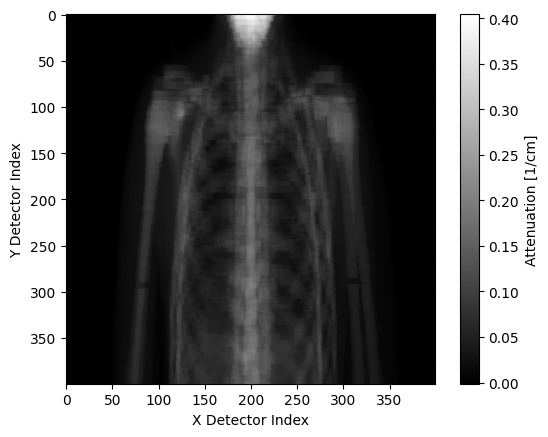

In [42]:
pos = plt.imshow(prep[0][::-1], cmap='gray')
plt.colorbar(pos,label='Attenuation [1/cm]')
plt.xlabel("X Detector Index")
plt.ylabel("Y Detector Index")

## Questions
1. How does mA and time affect noise levels?
2. How does kVp affect noise?
3. What does filtration do?
4. What happens when youmm change detector pixel size and magnification source-to-image distance and source-to-detector image (sid, sdd)?